In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tensorflow.python.keras import layers
import tensorflow_probability as tfp
from tensorflow.python.keras.callbacks import Callback
from sklearn.model_selection import train_test_split


import functions.parse_data as parse
import functions.models as md
import functions.handy_functions as hf

In [2]:

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])

## Train 5 layer model with 64 neurons per hidden layer.

In [3]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','COT','Cloud_Type','Profile_ID','GOT','Water_Vapor']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.

y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)
num_epochs=20
batch_size=100
model, history_df, X_test,y_test=md.train_5layer_64neurons_model(df,x_labels=X_labels,y_labels=y_labels,split=[0.6,0.2,0.2],epochs=num_epochs,batch_size=batch_size)



Epoch 1/20

1280/1280 [==============================] - 48s 38ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/20
1280/1280 [==============================] - 45s 35ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 3/20
1280/1280 [==============================] - 46s 36ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 4/20
1280/1280 [==============================] - 44s 35ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 5/20
1280/1280 [==============================] - 47s 36ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/20
1280/1280 [==============================] - 45s 35ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 7/20
1280/1280 [==============================] - 44s 34ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 8/20
1280/1280 [=======================

In [4]:
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=2)
print(f"Test mse: {test_mse}")

1250/1250 - 11s - loss: 0.0028 - mse: 0.0028 - 11s/epoch - 9ms/step
Test mse: 0.0028433878906071186


In [5]:
y_predict=model.predict(X_test)

1250/1250 [==============================] - 5s 4ms/step


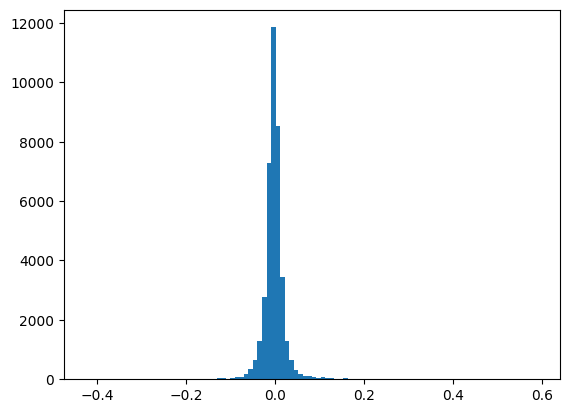

In [13]:
y_test_np=y_test.to_numpy()
channel=6
plt.hist(y_predict[:,channel]-y_test_np[:,channel],bins=100)
plt.show()

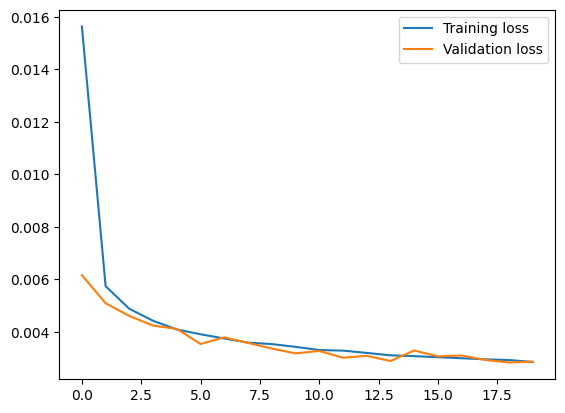

In [7]:
plt.plot(history_df['training_loss'])
plt.plot(history_df['validation_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.show()

## Train a first bayesian network

In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','COT','Cloud_Type','Profile_ID','GOT','Water_Vapor']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.

y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)
num_epochs=5
batch_size=100
model, history_df, X_test,y_test=md.train_first_bayesian_model(df,x_labels=X_labels,y_labels=y_labels,split=[0.6,0.2,0.2],epochs=num_epochs,batch_size=batch_size)

Epoch 1/5
1280/1280 [==============================] - 85s 66ms/step - loss: 147.6908 - mse: 0.5896 - val_loss: 28.7536 - val_mse: 0.2503
Epoch 2/5
1280/1280 [==============================] - 87s 68ms/step - loss: 11.0991 - mse: 0.1546 - val_loss: 3.7461 - val_mse: 0.0883
Epoch 3/5
1280/1280 [==============================] - 82s 64ms/step - loss: 2.7500 - mse: 0.0681 - val_loss: 2.2311 - val_mse: 0.0577
Epoch 4/5
1280/1280 [==============================] - 77s 60ms/step - loss: 2.1335 - mse: 0.0546 - val_loss: 1.9556 - val_mse: 0.0523
Epoch 5/5
1280/1280 [==============================] - 81s 63ms/step - loss: 2.0392 - mse: 0.0518 - val_loss: 1.9818 - val_mse: 0.0512


In [5]:
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=2)
print(f"Test mse: {test_mse}")

1250/1250 - 33s - loss: 2.0470 - mse: 0.0516 - 33s/epoch - 27ms/step
Test mse: 0.05160228908061981


In [6]:
y_predict=model.predict(X_test)

1250/1250 [==============================] - 35s 28ms/step


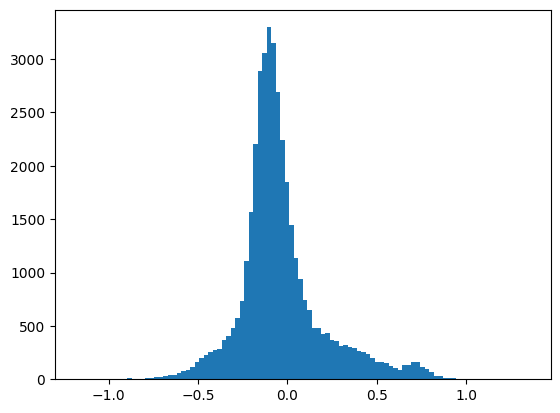

In [7]:
y_test_np=y_test.to_numpy()
channel=5
plt.hist(y_predict[:,channel]-y_test_np[:,channel],bins=100)
plt.show()

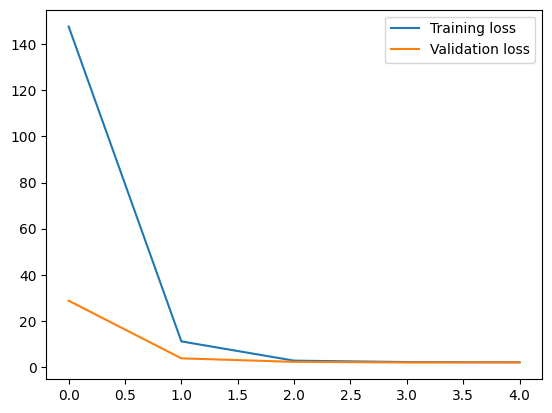

In [8]:
plt.plot(history_df['training_loss'])
plt.plot(history_df['validation_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.show()